# Quantum Support Vector Machines
----------------------------------------------------------------------------------------------------

## Part 1: Quantum Kernel Estimation (QKE)
Approach mainly inspired by Havlicek et al. (2019) [“Supervised learning with quantum enhanced feature spaces,” arXiv: 1804.11326](https://arxiv-org.ezproxy2.utwente.nl/pdf/1804.11326.pdf) and the [Quantum-enhanced Support Vector Machine](https://qiskit.org/documentation/stable/0.26/tutorials/machine_learning/01_qsvm_classification.html) Tutorial by Qiskit.

In [1]:
# Uncomment if needed
# %pip install 'qiskit-aqua[cvx]'

import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

# Uncomment or change according to preference
plt.style.use('default')
# Set Random Seed for controlled experiments
seed = 10599
aqua_globals.random_seed = seed

C:\Users\Noor1\AppData\Local\Temp/ipykernel_23272/2196026714.py:16: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  aqua_globals.random_seed = seed


### Classical Support Vector Machine on the ad_hoc dataset
We first try to visualize and make sense of the structure of the data. 
Then we will train a classical SVM model with a Radial Basis Function Kernel.

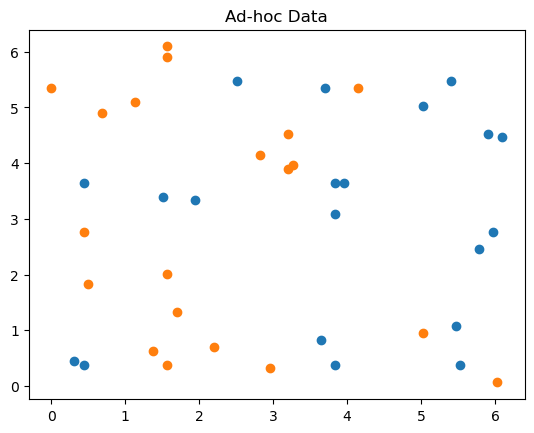

In [2]:
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data
# Variables:
feature_dim = 2

# Get Data: AD HOC Dataset with PCA 2 components; plot the data
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    gap=0.3, 
    plot_data=True
)

In [3]:
# Generate Extra test data for specific prediction later on
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

{'A': 0, 'B': 1}


In [4]:
# Function for printing classification results
def print_results(result, datapoints, svm):
    """Returns Testing Accuracy and prediction accuracy from the extra datapoints"""
    print(f'Testing Accuracy: {result["testing_accuracy"]}')
    print()
    print('Specific Prediction Examples:')
    print(f'  ground truth: {map_label_to_class_name(datapoints[1], svm.label_to_class)}')
#     map_label_to_class_name(datapoints[1], qsvm.label_to_class)
    print(f'  prediction:   {result["predicted_classes"]}')
    predicted_labels = result["predicted_labels"]
    print(f'  Prediction Sucess Rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')
    
# Function for printing the computed kernel matrix
def print_kernel(result):
    kernel_matrix = result['kernel_matrix_training']
    plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');


In [5]:
# Classical SVM
from qiskit.aqua.algorithms import SklearnSVM

# Train and Test classical SVM from SKlearn package
svm = SklearnSVM(training_input, test_input, datapoints[0])
result = svm.run()

# Print Classification results
print_results(result, datapoints, svm)

Testing Accuracy: 0.65

Specific Prediction Examples:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['B', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'A', 'B', 'A', 'B', 'B', 'A']
  Prediction Sucess Rate: 55.0%


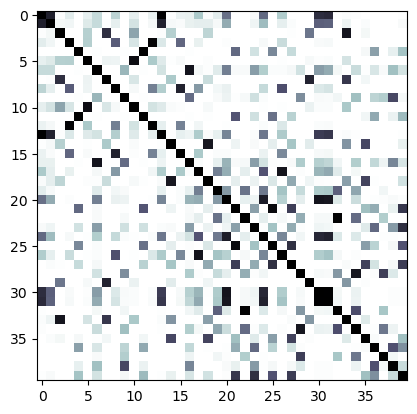

In [6]:
print_kernel(result)

### Quantum Support Vector Machine on the ad_hoc dataset
Now we will look into a bit more detail on how to approach the QSVM with the Quantum Kernel Estimation Approach. To encode the data into quantum space, we will use the ZZFeaturemap and look into how it is build. Then the general structure of the Kernel Estimation method will become more clear (for details refer to Emprical Investigation/Methodology Section of the paper. 

Looking into the Second-order Pauli-Z evolution circuit aka ZZFeatureMap

In [7]:
# Create Feature Map to convert data to quantum
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

feature_map.decompose().draw(fold = -1)

┌───┐┌─────────────┐                                          ┌───┐┌─────────────┐                                          
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘└─────────────┘└───┘└──────────────────────────────┘└───┘

This is the QSVM that is shown in figure 2: Quantum Kernel Estimation of the Report.
The general ansatz for the Quantum Kernel Estimation.

In [8]:
# Train and Test Quantum Support Vector Machine 
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

qsvm.construct_circuit([1],[2]).decompose().draw(fold = -1)

┌───────────────────────┐┌──────────────────────────┐
q_0: ┤0                      ├┤0                         ├
     │  ZZFeatureMap(1,x[1]) ││  ZZFeatureMap_dg(2,x[1]) │
q_1: ┤1                      ├┤1                         ├
     └───────────────────────┘└──────────────────────────┘
c: 2/═════════════════════════════════════════════════════

Simulate the QSVM algorithm 

In [9]:
# Run the simulator
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# Save Results
result = qsvm.run(quantum_instance)

print_results(result, datapoints, qsvm)

Testing Accuracy: 1.0

Specific Prediction Examples:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  Prediction Sucess Rate: 100.0%


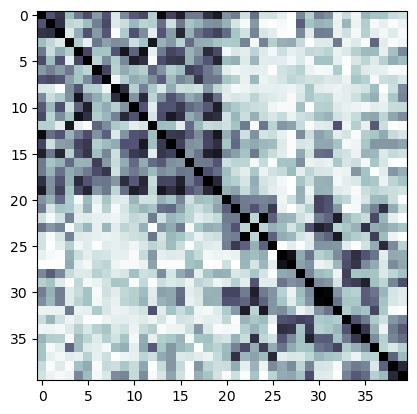

In [10]:
print_kernel(result)

### Classical SVM on Breast Cancer Data
We will also try it on different data sets with different structures but with the same approach:
1. Train and classify with classical SVM
2. Train and classify with QSVM

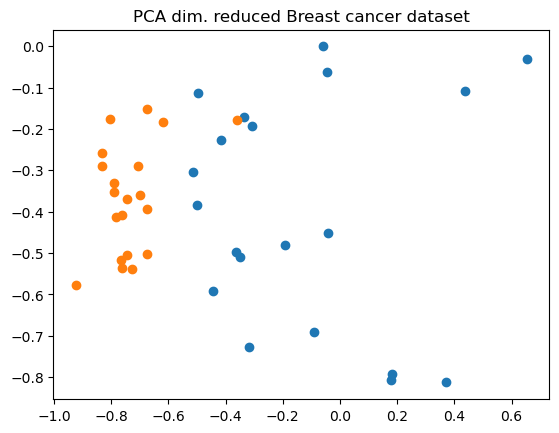

In [11]:
from qiskit.ml.datasets import breast_cancer
# Variables:
feature_dim = 2

# Get Data: AD HOC Dataset with PCA
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
#     gap=0.3, 
    plot_data=True
)

In [12]:
# Classical SVM
from qiskit.aqua.algorithms import SklearnSVM

# Train and Test classical SVM from SKlearn package
svm = SklearnSVM(training_input, test_input)
result = svm.run()

# Print Classification results
print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.85


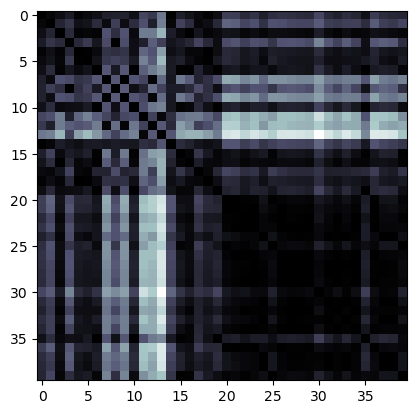

In [13]:
print_kernel(result)

### Quantum SVM on Breast Cancer Data

In [14]:
# Create Feature Map to convert data to quantum
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
# Train and Test Quantum Support Vector Machine 
qsvm = QSVM(feature_map, training_input, test_input)
# Run the simulator
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# Save Results
result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.9


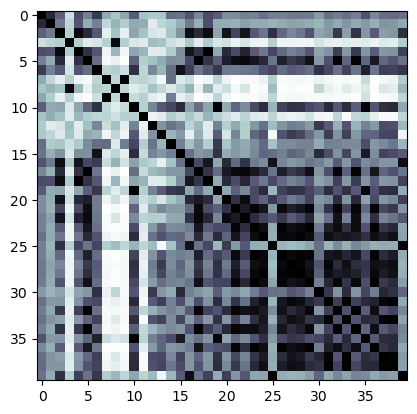

In [15]:
print_kernel(result)

### Classical SVM on Gaussians Data 

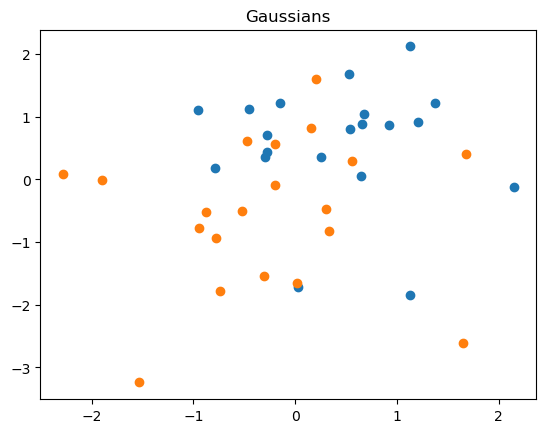

In [16]:
from qiskit.ml.datasets import gaussian
# Variables:
feature_dim = 2

# Get Data: AD HOC Dataset with PCA
sample_total, training_input, test_input, class_labels = gaussian(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
#     gap=0.3, 
    plot_data=True
)

In [17]:
# Classical SVM
from qiskit.aqua.algorithms import SklearnSVM

# Train and Test classical SVM from SKlearn package
svm = SklearnSVM(training_input, test_input)
result = svm.run()

# Print Classification results
print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.55


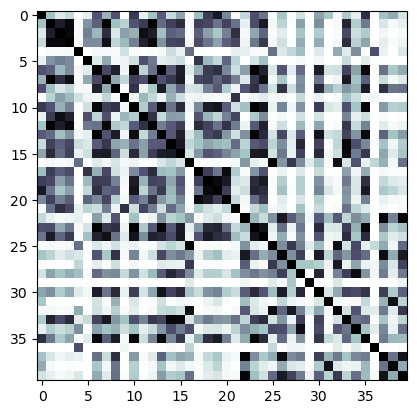

In [18]:
print_kernel(result)

### Quantum SVM on Gaussian Data

In [19]:
# Create Feature Map to convert data to quantum
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
# Train and Test Quantum Support Vector Machine 
qsvm = QSVM(feature_map, training_input, test_input)
# Run the simulator
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# Save Results
result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.5


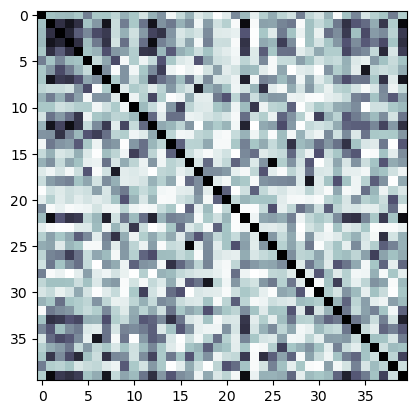

In [20]:
print_kernel(result)

## Mutliclass Classification
For the multiclass classification, we choose to use the OneAgainstRest method for multiclass SVM classification, due to its computational advantage. The one-against-rest method creates $n$ SVM classifiers, where the $i$-th classifier trains to classify class $i$ from all other classes $\forall i \in {1,2, \dots, n}$.
### Classic SVM on Wine Data (3 classes)

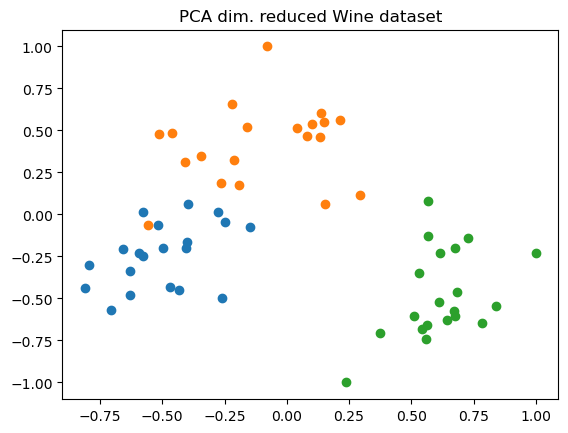

In [21]:
from qiskit.ml.datasets import wine
# Variables:
feature_dim = 2

# Get Data: AD HOC Dataset with PCA
sample_total, training_input, test_input, class_labels = wine(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
#     gap=0.3, 
    plot_data=True
)

In [22]:
# Classical SVM
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs, OneAgainstRest, ErrorCorrectingCode

# Multiclass classification method
multiclass_ext = OneAgainstRest()
# Train and Test classical SVM from SKlearn package
svm = SklearnSVM(training_input, test_input, multiclass_extension=multiclass_ext)
result = svm.run()

# Print Classification results
print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 1.0


### Quantum Multiclass SVM on Wine

In [23]:
# Create Feature Map to convert data to quantum
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
# Train and Test Quantum Support Vector Machine 
qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension=multiclass_ext)
# Run the simulator
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# Save Results
result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.8


### Classic SVM on Iris Data (3 classes)

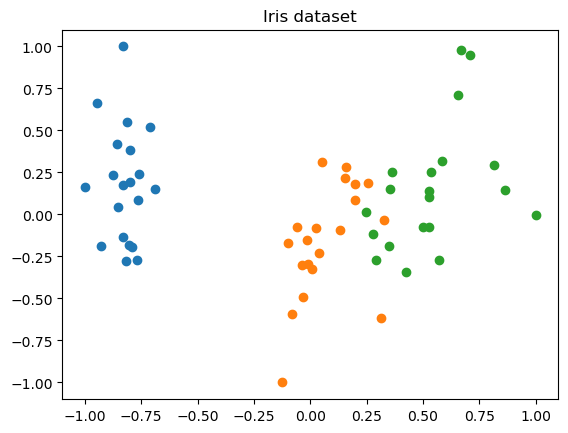

In [24]:
from qiskit.ml.datasets import iris
# Variables:
feature_dim = 2

# Get Data: AD HOC Dataset with PCA
sample_total, training_input, test_input, class_labels = iris(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
#     gap=0.3, 
    plot_data=True
)

In [25]:
# Classical SVM
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs, OneAgainstRest, ErrorCorrectingCode

# Variables
multiclass_ext = OneAgainstRest() #ErrorCorrectingCode(code_size=5)
# Train and Test classical SVM from SKlearn package
svm = SklearnSVM(training_input, test_input, multiclass_extension=multiclass_ext)
result = svm.run()

# Print Classification results
print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 1.0


### Quantum SVM on Iris Data (3 classes)

In [26]:
# Create Feature Map to convert data to quantum
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
# Train and Test Quantum Support Vector Machine 
qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension=multiclass_ext)
# Run the simulator
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# Save Results
result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 1.0


### Classic SVM on Digits Data (9 classes)

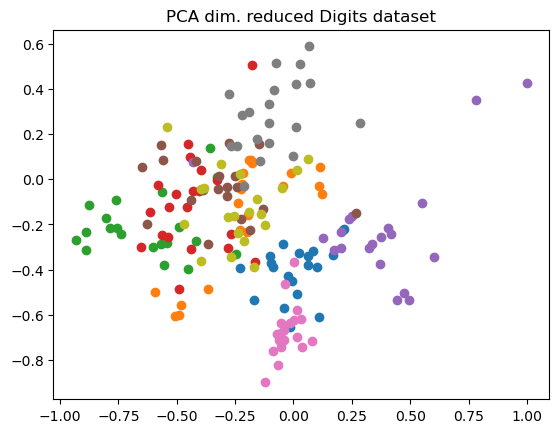

In [27]:
from qiskit.ml.datasets import digits
# Variables:
feature_dim = 2

# Get Data: AD HOC Dataset with PCA
sample_total, training_input, test_input, class_labels = digits(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
#     gap=0.3, 
    plot_data=True
)

In [28]:
# Classical SVM
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs, OneAgainstRest, ErrorCorrectingCode

# Variables
multiclass_ext = OneAgainstRest() #ErrorCorrectingCode(code_size=5)
# Train and Test classical SVM from SKlearn package
svm = SklearnSVM(training_input, test_input, multiclass_extension=multiclass_ext)
result = svm.run()

# Print Classification results
print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.43999999999999995


### Quantum SVM on Digit Data (9 classes)

In [29]:
# Create Feature Map to convert data to quantum
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
# Train and Test Quantum Support Vector Machine 
qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension=multiclass_ext)
# Run the simulator
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# Save Results
result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')

Testing success ratio: 0.25


## Part 2: Quantum Kernel Alignment
In this part we will try to build a trainable parameterized circuit that we can train to obtain the best quantum kernel based on J. R. Glick, T. P. Gujarati, A. D. Córcoles, Y. Kim, A. Kandala, J. M. Gambetta, K. Temme, "Covariant quantum kernels for data with group structure", (2021) [arXiv:2105.03406](https://arxiv-org.ezproxy2.utwente.nl/abs/2105.03406)

In [30]:
from pylab import cm
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data

# Create Callback class to save data during training iterations
# and visualize loss over iterations later on
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

### QKA with adhoc Data

In [31]:
def plot_datapoints(x_train, y_train, x_test, y_test, adhoc_total):
    """Plot the classifcation region with nearest interpolation"""
    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="PiYG",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )
    # Plot the A train data points
    plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="g",
    label="A train",
    )
    # Plot the B train datpoints
    plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
    )
    # Plot the A test data points
    plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="g",
    edgecolors="w",
    label="A test",
    )
    # Plot the B test data points
    plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
    )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")


In [32]:
adhoc_dimension = 2
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

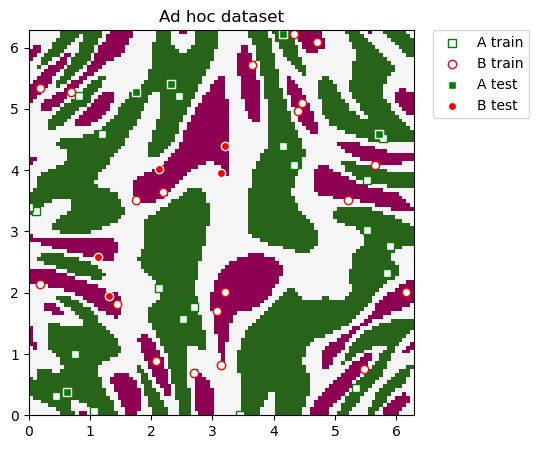

In [33]:
plot_datapoints(X_train, y_train, X_test, y_test, adhoc_total)

Create the parameterized ciruit with parameter $\theta$ that we will try to optimize to obtain a kernel that incoporates the structure of the data. 

In [34]:
# Define the trainable parameter that specifies the rotation of the quibit
user_params = ParameterVector("θ", 1)

# Create a rotational layer to train. 
fm = QuantumCircuit(2)
fm.ry(user_params[0], 0)
fm.ry(user_params[0], 1)

# Apply the ZZFeaturemap to decode data into quantum vectors
fm = fm.compose(ZZFeatureMap(2))

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


Initiate the Kernel Trainer class with the SVC Loss function that will optimize our parameters with the SPSA optimizer

In [35]:
# Use the qasm simulator backend
backend = AerSimulator(method="statevector")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
q_callback = QKTCallback()
optimizer_SPSA = SPSA(maxiter=10, callback=q_callback.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
kernel_trainer = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=optimizer_SPSA, initial_point=[np.pi / 2]
)

In [36]:
# Train the kernel using QKT directly
kernel_results = kernel_trainer.fit(X_train, y_train)
optimized_kernel = kernel_results.quantum_kernel
print(kernel_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): 1.7385880660111503},
    'optimal_point': array([1.73858807]),
    'optimal_value': 16.66230276108724,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002464747A9A0>}


In [37]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 1.0


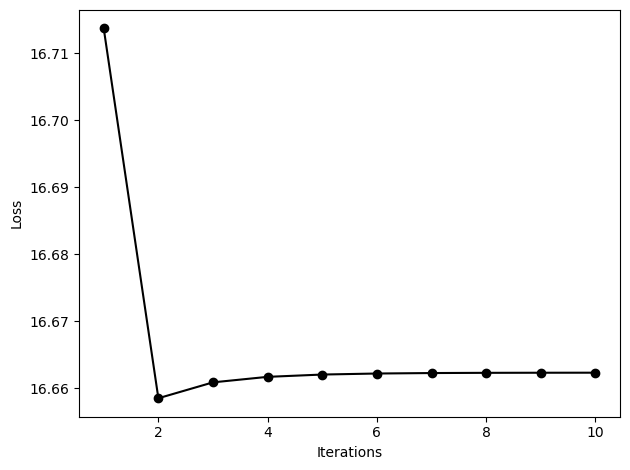

In [38]:
plot_data = q_callback.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

fig, ax = plt.subplots(1, 1) #figsize=(14, 5)
ax.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
fig.tight_layout()
plt.show()

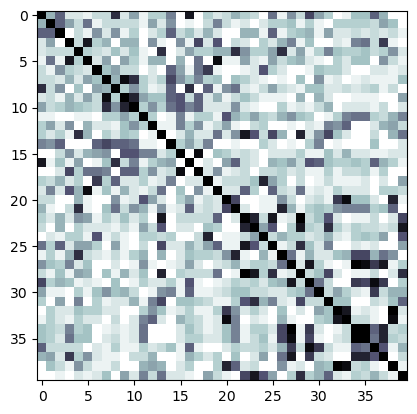

In [39]:
plt.imshow(K, cmap=cm.get_cmap("bone_r", 20))

### QKA with Gaussian
Same deal as before just with a new datasets and methods such that we do not cluter with code.

In [40]:
# Get the datapoints and labels
def get_train_test(training_input, test_input):    
    train_datapoints, _ = split_dataset_to_data_and_labels(training_input)
    X_train = train_datapoints[0]
    y_train = train_datapoints[1]

    test_datapoints, _ = split_dataset_to_data_and_labels(test_input)
    X_test = test_datapoints[0]
    y_test = test_datapoints[1]
    
    return X_train, y_train, X_test, y_test

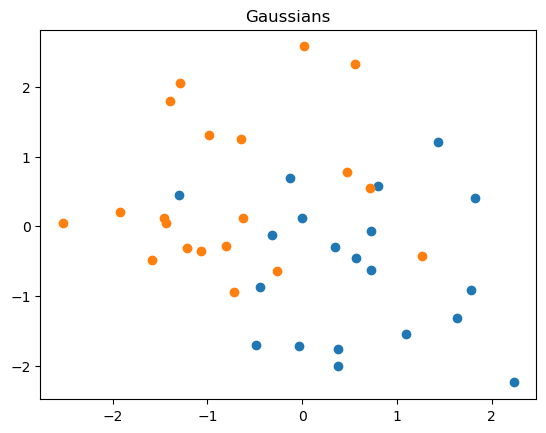

In [41]:
sample_total, training_input, test_input, class_labels = gaussian(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
#     gap=0.3, 
    plot_data=True
)

X_train, y_train, X_test, y_test = get_train_test(training_input, test_input)

In [42]:
def get_trainable_featuremap():
    # Define the trainable parameter that specifies the rotation of the quibit
    user_params = ParameterVector("θ", 1)

    # Create a rotational layer to train. 
    fm = QuantumCircuit(2)
    fm.ry(user_params[0], 0)
    fm.ry(user_params[0], 1)

    # Apply the ZZFeaturemap to decode data into quantum vectors
    fm = fm.compose(ZZFeatureMap(2))
    
    return fm, user_params


In [43]:
fm, user_params = get_trainable_featuremap()

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [44]:
def get_kernel_trainer(fm, user_params):
    # Use the qasm simulator backend
    backend = AerSimulator(method="statevector")

    # Instantiate quantum kernel
    quant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

    # Set up the optimizer
    q_callback = QKTCallback()
    optimizer_SPSA = SPSA(maxiter=10, callback=q_callback.callback, learning_rate=0.05, perturbation=0.05)

    # Instantiate a quantum kernel trainer.
    kernel_trainer = QuantumKernelTrainer(
        quantum_kernel=quant_kernel, loss="svc_loss", optimizer=optimizer_SPSA, initial_point=[np.pi / 2]
    )
    return kernel_trainer, q_callback

In [45]:
kernel_trainer, q_callback = get_kernel_trainer(fm, user_params)

In [46]:
# Train the kernel using QKT directly
kernel_results = kernel_trainer.fit(X_train, y_train)
optimized_kernel = kernel_results.quantum_kernel
print(kernel_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): 2.126586589322054},
    'optimal_point': array([2.12658659]),
    'optimal_value': 29.45926399517621,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x00000246476BDEE0>}


In [47]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.45


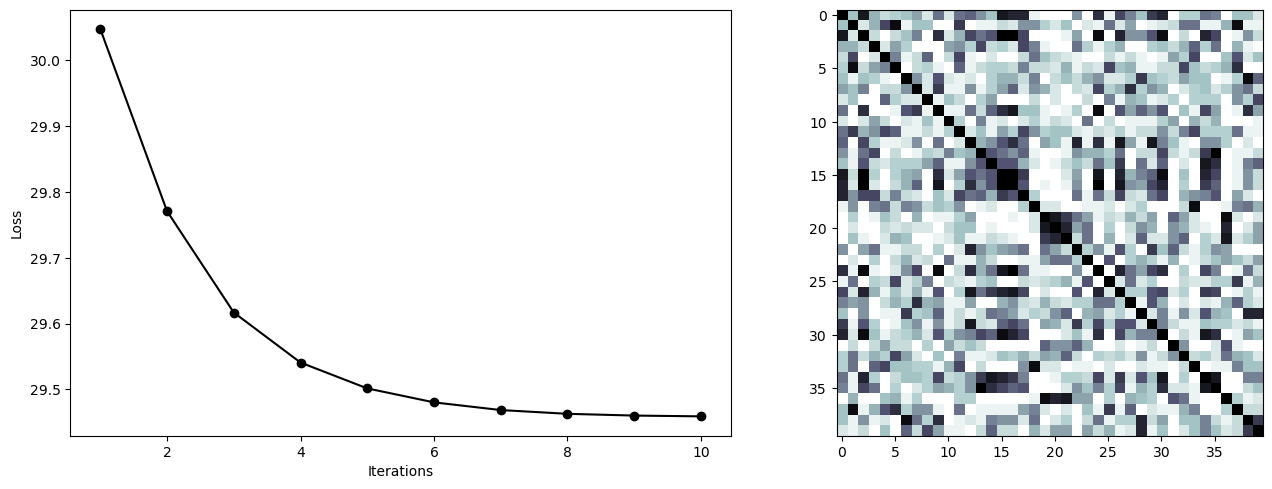

In [48]:
plot_data = q_callback.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

# plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bone_r", 20))
fig.tight_layout()
plt.show()

### QKA with Breast Cancer Data

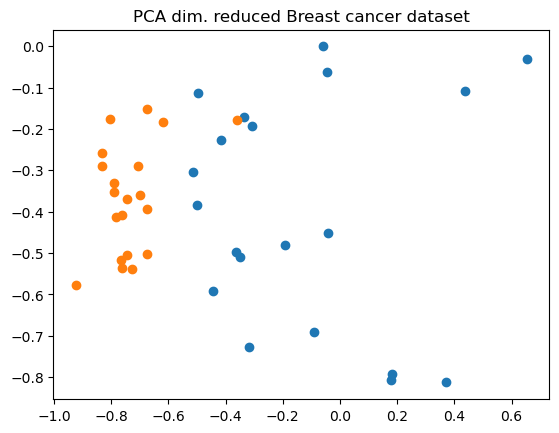

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1] [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [49]:
dimension = 2
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    plot_data=True
)

X_train, y_train, X_test, y_test = get_train_test(training_input, test_input)
print(y_train, y_test)

In [50]:
fm, user_params = get_trainable_featuremap()

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [51]:
# Create and Train the quantum Kernel trainer
kernel_trainer, q_callback = get_kernel_trainer(fm, user_params)
kernel_results = kernel_trainer.fit(X_train, y_train)
optimized_kernel = kernel_results.quantum_kernel
print(kernel_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): 1.5189503273203382},
    'optimal_point': array([1.51895033]),
    'optimal_value': 14.28706453667921,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000024647A9DEB0>}


In [52]:
# Classify with QSVC using our optimized quantum kernel
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the data
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.7


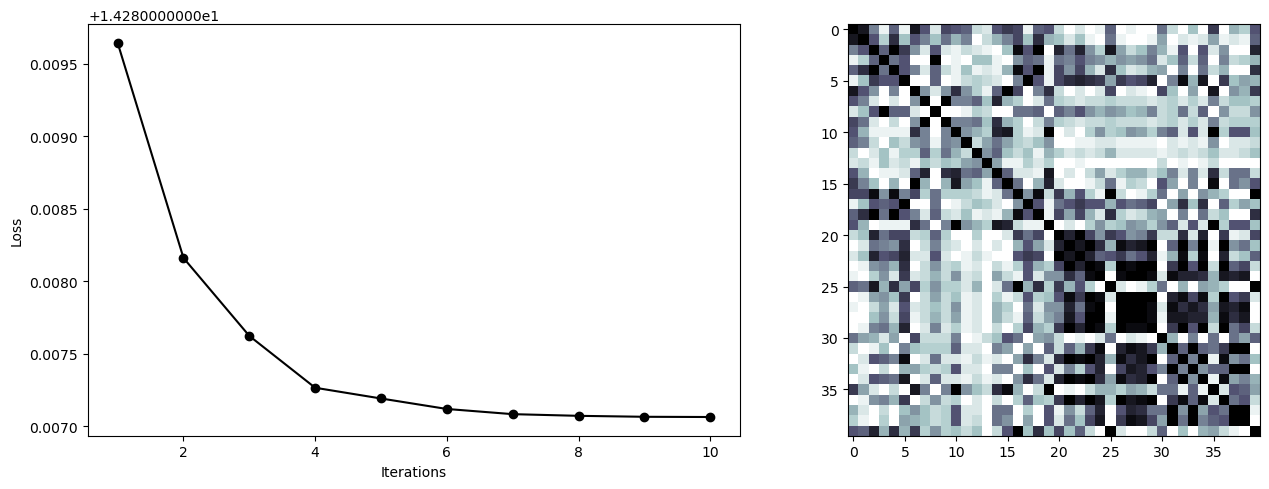

In [53]:
plot_data = q_callback.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

# plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bone_r", 20))
fig.tight_layout()
plt.show()

###  QKA with Iris data

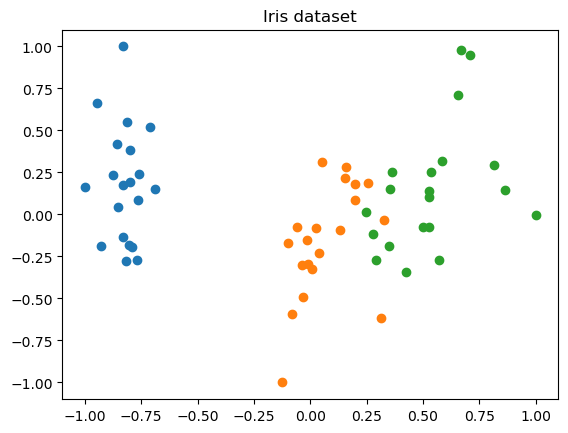

In [54]:
dimension = 2
sample_total, training_input, test_input, class_labels = iris(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    plot_data=True
)

X_train, y_train, X_test, y_test = get_train_test(training_input, test_input)

In [55]:
fm, user_params = get_trainable_featuremap()

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [56]:
# Create and Train the quantum Kernel trainer
kernel_trainer, q_callback = get_kernel_trainer(fm, user_params)
kernel_results = kernel_trainer.fit(X_train, y_train)
optimized_kernel = kernel_results.quantum_kernel
print(kernel_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): 1.6043187504351497},
    'optimal_point': array([1.60431875]),
    'optimal_value': 4.272167767450309,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002464B1E5130>}


In [57]:
# Classify with QSVC using our optimized quantum kernel
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the data
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 1.0


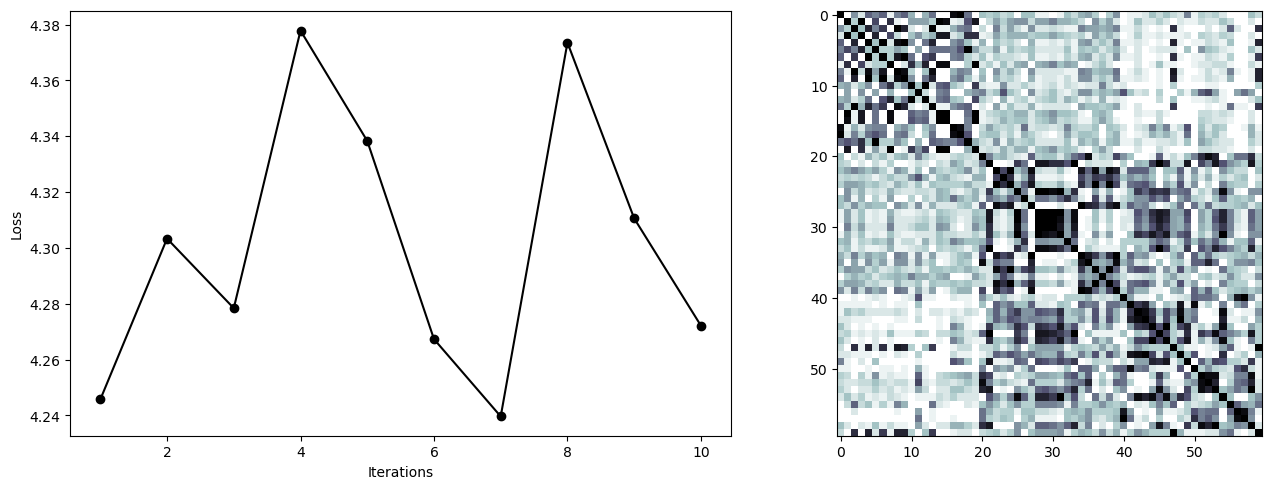

In [58]:
plot_data = q_callback.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

# plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bone_r", 20))
fig.tight_layout()
plt.show()

### QKA with Wine data

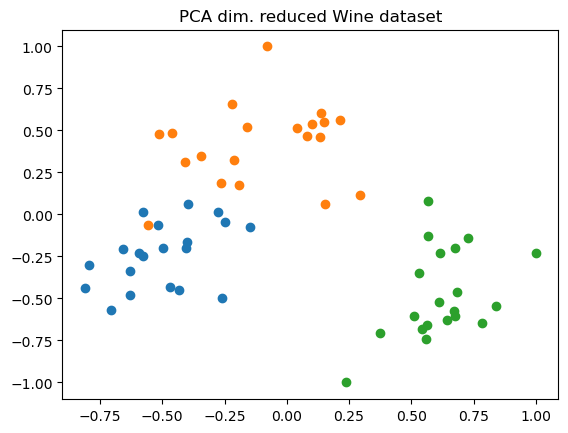

In [59]:
dimension = 2
sample_total, training_input, test_input, class_labels = wine(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    plot_data=True
)

X_train, y_train, X_test, y_test = get_train_test(training_input, test_input)

In [60]:
fm, user_params = get_trainable_featuremap()

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [61]:
# Create and Train the quantum Kernel trainer
kernel_trainer, q_callback = get_kernel_trainer(fm, user_params)
kernel_results = kernel_trainer.fit(X_train, y_train)
optimized_kernel = kernel_results.quantum_kernel
print(kernel_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): 2.497684586058414},
    'optimal_point': array([2.49768459]),
    'optimal_value': 7.562136262618495,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000024646FEBEE0>}


In [62]:
# Classify with QSVC using our optimized quantum kernel
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the data
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.9333333333333332


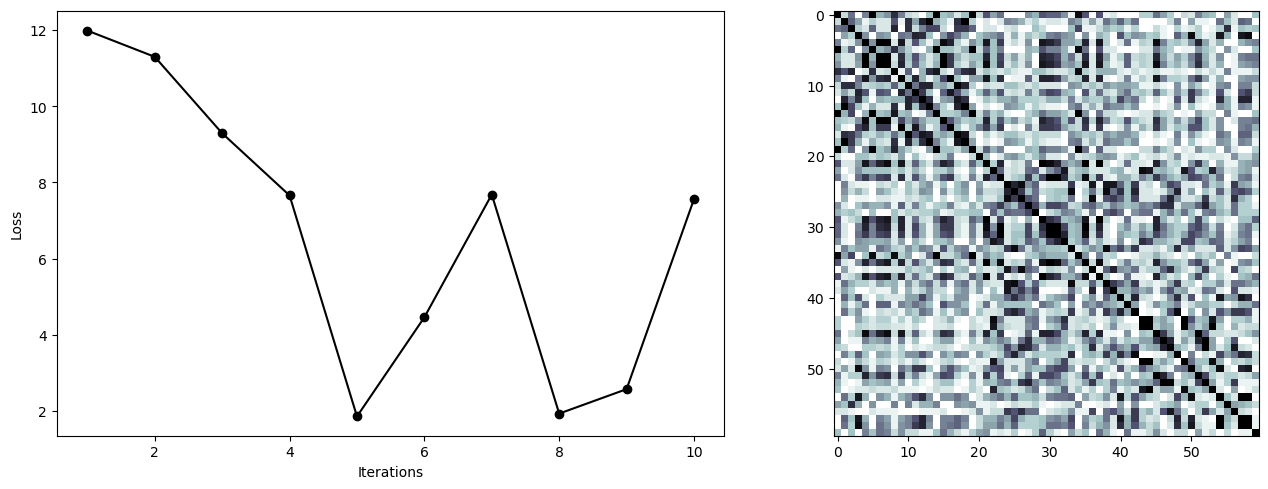

In [63]:
plot_data = q_callback.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

# plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bone_r", 20))
fig.tight_layout()
plt.show()

###  QKA with Digits

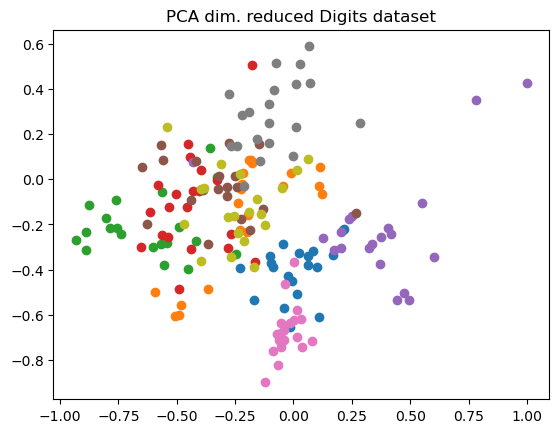

In [64]:
dimension = 2
sample_total, training_input, test_input, class_labels = digits(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    plot_data=True
)

X_train, y_train, X_test, y_test = get_train_test(training_input, test_input)

In [65]:
fm, user_params = get_trainable_featuremap()

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [66]:
# Create and Train the quantum Kernel trainer
kernel_trainer, q_callback = get_kernel_trainer(fm, user_params)
kernel_results = kernel_trainer.fit(X_train, y_train)
optimized_kernel = kernel_results.quantum_kernel
print(kernel_results)

{   'optimal_parameters': {ParameterVectorElement(θ[0]): 41.37496933822314},
    'optimal_point': array([41.37496934]),
    'optimal_value': -1961.389487087795,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000002464B9C77F0>}


In [67]:
# Classify with QSVC using our optimized quantum kernel
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the data
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.4800000000000001


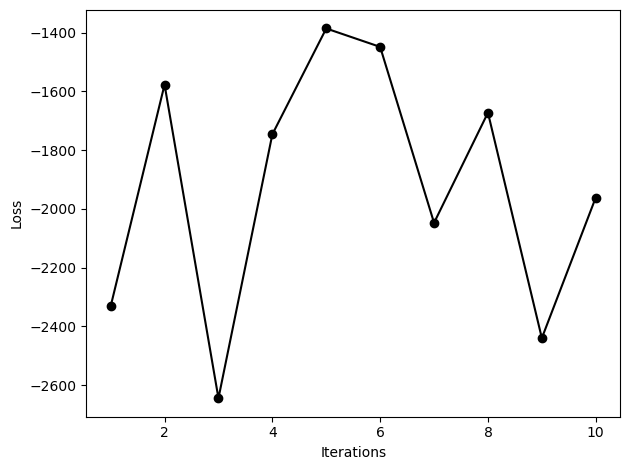

In [68]:
plot_data = q_callback.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

fig, ax = plt.subplots(1, 1) #figsize=(14, 5)
ax.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
fig.tight_layout()
plt.show()

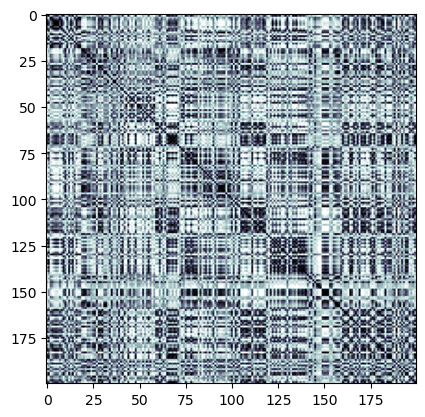

In [69]:
plt.imshow(K, cmap=cm.get_cmap("bone_r", 20))